# **FNO approach**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/DL_Final_Project

/content/drive/MyDrive/DL_Final_Project


In [ ]:
!unzip /content/drive/MyDrive/DL_Final_Project/dataset_dlproject

Archive:  /content/drive/MyDrive/DL_Final_Project/dataset_dlproject
replace perms_clear.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import notebook, tqdm

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
import wandb

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
display(device)

device(type='cuda')

In [ ]:
# https://wandb.ai/quickstart

!wandb login  # and paste your API key from https://wandb.ai/authorize

wandb: Currently logged in as: cherepanovegor2018. Use `wandb login --relogin` to force relogin


In [ ]:
perm = np.load('perms_clear.npy')
pressure = np.load('pressures_clear.npy')

print('perm shape:', perm.shape)
print('pressure shape:', pressure.shape)

perm shape: (1317, 64, 64)
pressure shape: (1317, 21, 64, 64)


In [ ]:
# # 1 map of perm, 3 maps of pressures
# x, y = [], []
# for i in notebook.tqdm(range(len(pressure))):
#     x.append(perm[i].reshape(1, 64, 64))
#     y.append(pressure[i][1:4, :, :])

# x = np.stack(tuple(x))
# y = np.stack(tuple(y))

# print('x:', x.shape)
# print('y:', y.shape)

In [ ]:
x = []
for i in notebook.tqdm(range(len(pressure))):
    x.append(pressure[i][1].reshape(1,64,64))
    # x.append(perm[i].reshape(1,64,64))
    
x = np.stack(tuple(x))
y = pressure[:,2:5]
# y = pressure[:,2:]

print('x:', x.shape)
print('y:', y.shape)

  0%|          | 0/1317 [00:00<?, ?it/s]

x: (1317, 1, 64, 64)
y: (1317, 3, 64, 64)


In [ ]:
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42, shuffle=False)
print(f'The train size: {len(x_train)}',
      f'\nThe val size: {len(x_val)}',
     f'\nThe test size: {len(x_test)}')

x_train = torch.from_numpy(x_train)
x_val = torch.from_numpy(x_val)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
y_test = torch.from_numpy(y_test)

The train size: 1053 
The val size: 132 
The test size: 132


In [ ]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=2)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
from torch.fft import fft2, ifft

In [ ]:
class FNO(nn.Module):
    def __init__(self, modes):
        super(FNO, self).__init__()
        self.modes = modes
        # Lift to higher dimension channel space
        self.lift = nn.Conv2d(1, 64, kernel_size=1, padding=1)
        
        # Fourier layers
        self.fourier1 = Fourier(modes=self.modes)
        self.fourier2 = Fourier(modes=self.modes)

        # Integral operators and activation functions 
        self.op1 = Block(64, 64)
        self.op2 = Block(64, 64)
        self.op3 = Block(64, 64)
        self.op4 = Block(64, 64)

        # Project back to target dimension
        self.proj = nn.Conv2d(64, 3, kernel_size=1)
        
    def forward(self, x):
        # Lift to higher dimension channel space
        x = self.lift(x)
        
        # Fourier layers
        x = self.fourier1(x)
        
        # Integral operators and activation functions 
        x = self.op1(x)
        x = self.op2(x)
        x = self.op3(x)
        x = self.op4(x)
        
        # Fourier layers
        x = self.fourier2(x)
        
        # Project back to target dimension
        x = self.proj(x)
        return x

class Fourier(nn.Module):
    def __init__(self, modes):
        super(Fourier, self).__init__()
        self.modes = modes
    def forward(self, x):
        b, c, h, w = x.size()

        # Convert to frequency domain
        x_fft = torch.fft.rfft(x.view(b, c, h, w))

        # Filter out high frequency modes
        x_low_freq = torch.zeros_like(x_fft)
        x_low_freq[:,:,:,0:self.modes] = x_fft[:,:,:,0:self.modes]
      
        # Convert back to spatial domain
        x_ifft = torch.fft.irfft(x_low_freq)
        x_ifft = x_ifft.view(b, c, h, w)

        # Apply local linear transform
        #x_ifft = nn.Conv2d(64, 64, kernel_size=3, padding=1, device=device)(x_ifft)

        return x_ifft


class Block(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(Block, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=1, padding=1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu3 = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        # Add residual connection
        out += identity

        out = self.relu3(out)
        return out

In [ ]:
def train(model, criterion, train_loader, val_loader, scheduler=None, 
             path ='/home/', name='name.pth',
             num_epochs=100, learning_rate=3e-4):
  
    opt = torch.optim.Adam(model.parameters(), learning_rate)

    logging = []
    best_val_loss = np.inf
    val_loss = 0
    f = 0
    pbar = notebook.tqdm(range(num_epochs), colour="MAGENTA")
    for epoch in pbar:
        model.train()
        
        train_batch_loss = []
        for step, batch in enumerate(train_loader):
            sample, target = batch
            sample, target = sample.to(device, torch.float), target.to(device, torch.float) 
            pred = model(sample)
            loss = criterion(pred, target)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_batch_loss.append(loss.item())
            pbar.set_description(f"Epoch: {epoch+1} / {num_epochs}, Batch: {step+1} / {len(train_loader)}, Train Loss: {train_batch_loss[-1]:.4f}, Val Loss: {val_loss:.2f}, ES Ticker: {f} / {10}")
        train_loss = np.mean(train_batch_loss)
    
        model.eval()
        
        val_batch_loss = []
        for batch in val_loader:
            sample, target = batch
            sample, target = sample.to(device, torch.float), target.to(device, torch.float)
            
            pred = model(sample)
            loss = criterion(pred, target)
            val_batch_loss.append(loss.item())
            
        val_loss = np.mean(val_batch_loss)
        
        # if epoch % 100 == 0:
        #     folder = path
        #     model_name = f'PINN_non_steady_{epoch}.pth'
        #     model_path = folder + model_name
        #     torch.save(model, model_path)

        wandb.log({'Train Loss': train_loss, 'Val Loss': val_loss})

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            folder = path
            model_path = folder + name
            torch.save(model, model_path)
        
        if scheduler is not None:
            scheduler.step()
            
        logging.append(np.array([epoch, train_loss, val_loss]))
        if val_loss > np.min(logging, axis=0)[2]:
            f += 1
        else:
            f = 0
            # folder = path
            # model_name_cur = 'PINN_non_steady_current_sch.pth'
            # model_path = folder + model_name_cur
            # torch.save(model, model_path)
        
        # if f >= 10:
        #     print("Early stopping...")
        #     break

        #print(f'epoch: {epoch}, train_loss: {train_loss}, val_loss {val_loss}')

    return logging

In [ ]:
def main(config):
    lr =  config['lr']
    num_epochs = config['num_epochs']
    batch_size = config['batch_size']
    modes = config['modes']
    wandb.init(project="Custom_FNO", name = "test_run", config=config)

    criterion = nn.MSELoss()
    scheduler = None
    model = FNO(modes=modes).to(device)

    batch_size = batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

    print('Lenght of dataloader: \t', len(train_loader))

    logs = train(model, criterion, train_loader, val_loader, scheduler, 
             path='/content/drive/MyDrive/DL_Final_Project/results/FNO/',
             name='FNO_best.pth',
             num_epochs=num_epochs, learning_rate=lr)

    return logs

In [ ]:
config = {
    'lr': 1e-3,
    'num_epochs': 1000,
    'batch_size': 64,
    'modes': 16}

#wandb.init(project="DL_HW_3_GAN", name = "test_run", config=config)
logs = main(config)

In [ ]:
# model = FNO(dropout_prob=0.2, modes=16).to(device)
# lr = 1e-4
# opt = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-3)
# num_epochs = 500
# scheduler = None
# criterion = nn.MSELoss()

# logs = train(model, criterion, train_loader, val_loader, scheduler, 
#              path='/content/drive/MyDrive/DL_Final_Project/results/FNO/',
#              name='FNO_best.pth',
#              num_epochs=num_epochs, learning_rate=lr)

In [ ]:
def logging_plot(logging, save_name='some_logging'):
    logging = np.array(logging)
    plt.plot(logging[:,0], logging[:,1], label='train_loss')
    plt.plot(logging[:,0], logging[:,2], label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.ylim(np.min(logging[15:]), np.max(logging[15:]))
    # np.save(f'{save_name}.npy', logging)

In [1]:
# logging_plot(logs, 'piwsm_logging_unet')

In [ ]:
folder = '/content/drive/MyDrive/DL_Final_Project/results/FNO/'
model_name_cur = 'FNO_best.pth'

In [ ]:
model_path_cur = folder + model_name_cur
model = torch.load(model_path_cur)
model.to(device)
model.eval()
model.to(device)

FNO(
  (lift): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fourier1): Fourier()
  (fourier2): Fourier()
  (op1): Block(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
  )
  (op2): Block(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, 

In [ ]:
len(test_dataset)

132

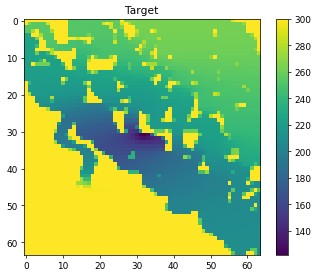

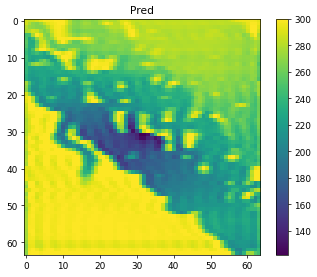

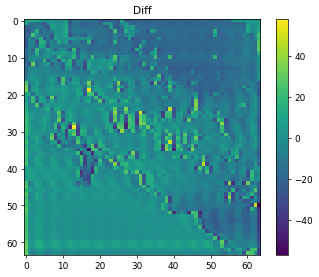

In [ ]:
# 3 на 10
ex_x, ex_y = test_dataset[0]
ex_pred = model(ex_x.unsqueeze(0).to(device, dtype=torch.float)).cpu().detach().numpy()[0]

k = 2
target = ex_y.numpy()[k]
pred = ex_pred[k]
diff = ex_y.numpy()[k] - ex_pred[k]
dpi = 64

plt.figure(dpi=dpi)
plt.imshow(target, vmin=target.min(), vmax=target.max())
plt.subplots_adjust()
plt.colorbar()
plt.title('Target')
plt.show()

plt.figure(dpi=dpi)
plt.imshow(pred, vmin=target.min(), vmax=target.max())
plt.subplots_adjust()
plt.colorbar()
plt.title('Pred')
plt.show()

plt.figure(dpi=dpi)
plt.imshow(diff)
plt.subplots_adjust()
plt.colorbar()
plt.title('Diff')
plt.show()

In [ ]:
test_loss = []
criterion = nn.MSELoss()
for i in tqdm(range(len(test_dataset))):
    sample, target = test_dataset[i]
    sample, target = sample.to(device, torch.float), target.to(device, torch.float).unsqueeze(0)
    pred = model(sample.unsqueeze(0))
    loss = criterion(pred, target)
    test_loss.append(loss.item())

print(np.sqrt(np.mean(test_loss)))

100%|██████████| 132/132 [00:01<00:00, 124.65it/s]

7.602988701582081
